# Backpropagation Implementation with 1000 Epochs

This notebook implements a neural network with:
- Forward Pass (FP)
- Backpropagation (BP)
- Weight Update
- Training for 1000 epochs

**Required packages:**
1. Numpy
2. NNFS - for the Spiral dataset
3. scikit-learn - for the Iris dataset

In [1]:
# Library imports
import numpy as np

## Layer Class - Dense Layer

In [2]:
# Hidden Layers
# Dense
class Layer_Dense:
    # Layer initialization
    # randomly initialize weights and set biases to zero
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, inputs):
        # Remember the input values
        self.inputs = inputs
        # Calculate the output values from inputs, weight and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass/Backpropagation
    def backward(self, dvalues):
        # Gradients on parameters:
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

## Activation Functions

In [3]:
# Activation Functions
# Included here are the functions for both the forward and backward pass

# ReLU
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Remember the input values
        self.inputs = inputs
        # Calculate the output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Make a copy of the original values first
        self.dinputs = dvalues.copy()
    
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

# Softmax
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        # Remember the inputs values
        self.inputs = inputs

        # Get the unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):

            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate the sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

## Loss Functions

In [4]:
# Loss functions

class Loss:
    # Calculate the data and regularization losses
    # Given the model output and ground truth/target values
    def calculate(self, output, y):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate the mean loss
        data_loss = np.mean(sample_losses)
        # Return the mean loss
        return data_loss

# Categorical Cross-Entropy
class Loss_CategoricalCrossEntropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = y_pred.shape[0]

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values
        # Only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # Use the first sample to count them
        labels = len(dvalues[0])

        # Check if labels are sparse, turn them into one-hot vector values
        # the eye function creates a 2D array with ones on the diagonal and zeros elsewhere
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate the gradient
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples

## Optimizer - Stochastic Gradient Descent (SGD)

In [5]:
# Optimizer supporting SGD, learning rate decay, momentum, and AdaGrad
class Optimizer_SGD:
    def __init__(self, learning_rate=1.0, decay=0.0, momentum=0.0, adagrad=False):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
        self.adagrad = adagrad

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay * self.iterations))
        else:
            self.current_learning_rate = self.learning_rate

    def update_params(self, layer):
        # Momentum - Formula: θ_new = θ - ((η * ∂E/∂θ) + (γ * Δθ^(t-1)))
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            # Calculate weight updates: (η * ∂E/∂θ) + (γ * Δθ^(t-1))
            weight_updates = (self.current_learning_rate * layer.dweights) + (self.momentum * layer.weight_momentums)
            bias_updates = (self.current_learning_rate * layer.dbiases) + (self.momentum * layer.bias_momentums)
            
            # Store the updates for next iteration (Δθ^t)
            layer.weight_momentums = weight_updates
            layer.bias_momentums = bias_updates
            
            # Apply updates: θ_new = θ - weight_updates
            layer.weights -= weight_updates
            layer.biases -= bias_updates
        
        # AdaGrad
        elif self.adagrad:
            if not hasattr(layer, 'weight_cache'):
                layer.weight_cache = np.zeros_like(layer.weights)
                layer.bias_cache = np.zeros_like(layer.biases)
            layer.weight_cache += layer.dweights ** 2
            layer.bias_cache += layer.dbiases ** 2
            layer.weights -= self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + 1e-7)
            layer.biases -= self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + 1e-7)
        
        # Standard SGD (no momentum, no adagrad)
        else:
            layer.weights -= self.current_learning_rate * layer.dweights
            layer.biases -= self.current_learning_rate * layer.dbiases

    def post_update_params(self):
        self.iterations += 1

## Load Dataset - Spiral Data

In [6]:
# Spiral Data
import nnfs
from nnfs.datasets import spiral_data

# Create the dataset
X, y = spiral_data(samples=100, classes=3)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"First 5 samples of X:\n{X[:5]}")
print(f"First 5 labels: {y[:5]}")

X shape: (300, 2)
y shape: (300,)
First 5 samples of X:
[[ 0.          0.        ]
 [ 0.00315936  0.00959421]
 [-0.00143464  0.02015102]
 [ 0.00382457  0.03006071]
 [ 0.01937866  0.03545355]]
First 5 labels: [0 0 0 0 0]


## Neural Network Initialization

In [7]:
# Neural Network initialization
# Create a Dense Layer with 2 input features and 3 output values
dense1 = Layer_Dense(2, 3)

# Create a ReLU activation for the first Dense layer
activation1 = Activation_ReLU()

# Create a 2nd dense layer with 3 input and 3 output values
dense2 = Layer_Dense(3, 3)

# Create a Softmax activation for the 2nd Dense layer
activation2 = Activation_Softmax()

# Create a loss function
loss_function = Loss_CategoricalCrossEntropy()

# Create the optimizer with a learning rate
optimizer = Optimizer_SGD(learning_rate=1.0)

print("Neural Network initialized successfully!")

Neural Network initialized successfully!


## Training Loop - 1000 Epochs

This cell performs:
1. **Forward Pass (FP)**: Data flows through the network
2. **Backpropagation (BP)**: Gradients are calculated backward
3. **Weight Update**: Optimizer updates weights and biases

The process repeats for 1000 epochs.

In [8]:
# Training loop for 1000 epochs
epochs = 1000

for epoch in range(epochs):
    # ===== PRE-UPDATE: LEARNING RATE DECAY =====
    # This must happen BEFORE Forward Pass and Backpropagation
    optimizer.pre_update_params()
    
    # ===== FORWARD PASS =====
    # Layer 1: Dense + ReLU
    dense1.forward(X)
    activation1.forward(dense1.output)
    
    # Layer 2: Dense + Softmax
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    
    # Calculate loss
    loss = loss_function.calculate(activation2.output, y)
    
    # Calculate accuracy
    predictions = np.argmax(activation2.output, axis=1)
    if len(y.shape) == 2:
        y_labels = np.argmax(y, axis=1)
    else:
        y_labels = y
    accuracy = np.mean(predictions == y_labels)
    
    # ===== BACKWARD PASS (BACKPROPAGATION) =====
    # Backward through loss
    loss_function.backward(activation2.output, y)
    
    # Backward through layer 2
    activation2.backward(loss_function.dinputs)
    dense2.backward(activation2.dinputs)
    
    # Backward through layer 1
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # ===== WEIGHT UPDATE (Momentum/AdaGrad/Vanilla SGD) =====
    # This happens AFTER learning rate decay
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    # Display progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss:.4f} | Accuracy: {accuracy:.4f} | LR: {optimizer.current_learning_rate:.6f}")

# Final results
print(f"\n{'='*50}")
print(f"Training Complete!")
print(f"Final Epoch: {epoch}")
print(f"Final Loss: {loss:.4f}")
print(f"Final Accuracy: {accuracy:.4f}")
print(f"Final Learning Rate: {optimizer.current_learning_rate:.6f}")
print(f"{'='*50}")

Epoch    0 | Loss: 1.0986 | Accuracy: 0.3533 | LR: 1.000000
Epoch  100 | Loss: 1.0965 | Accuracy: 0.4167 | LR: 1.000000
Epoch  100 | Loss: 1.0965 | Accuracy: 0.4167 | LR: 1.000000
Epoch  200 | Loss: 1.0720 | Accuracy: 0.4267 | LR: 1.000000
Epoch  200 | Loss: 1.0720 | Accuracy: 0.4267 | LR: 1.000000
Epoch  300 | Loss: 1.0697 | Accuracy: 0.4300 | LR: 1.000000
Epoch  300 | Loss: 1.0697 | Accuracy: 0.4300 | LR: 1.000000
Epoch  400 | Loss: 1.0685 | Accuracy: 0.4433 | LR: 1.000000
Epoch  400 | Loss: 1.0685 | Accuracy: 0.4433 | LR: 1.000000
Epoch  500 | Loss: 1.0680 | Accuracy: 0.4333 | LR: 1.000000
Epoch  500 | Loss: 1.0680 | Accuracy: 0.4333 | LR: 1.000000
Epoch  600 | Loss: 1.0676 | Accuracy: 0.4300 | LR: 1.000000
Epoch  600 | Loss: 1.0676 | Accuracy: 0.4300 | LR: 1.000000
Epoch  700 | Loss: 1.0673 | Accuracy: 0.4267 | LR: 1.000000
Epoch  700 | Loss: 1.0673 | Accuracy: 0.4267 | LR: 1.000000
Epoch  800 | Loss: 1.0670 | Accuracy: 0.4133 | LR: 1.000000
Epoch  800 | Loss: 1.0670 | Accuracy: 0.

## Summary

The neural network has been trained for 1000 epochs using:
- **Architecture**: 2 inputs → 3 neurons (ReLU) → 3 neurons (Softmax)
- **Loss Function**: Categorical Cross-Entropy
- **Optimizer**: Stochastic Gradient Descent (SGD)
- **Dataset**: Spiral data (300 samples, 3 classes)

Each epoch performs:
1. Forward propagation through all layers
2. Loss calculation
3. Backward propagation (computing gradients)
4. Weight and bias updates using SGD

## Optimizer Comparison

Now let's compare different optimizers to see:
- **How many epochs it takes to stabilize the loss**
- **The final accuracy achieved**

We'll test:
1. **Vanilla SGD** (no momentum, no decay)
2. **SGD with Momentum** (γ = 0.9)
3. **SGD with Learning Rate Decay** (decay = 0.001)
4. **SGD with AdaGrad**

In [9]:
# Function to train and track optimizer performance
def train_model(optimizer_config, epochs=1000):
    """
    Train the model with a specific optimizer configuration
    Returns: loss_history, accuracy_history, final_loss, final_accuracy, epochs_to_stabilize
    """
    # Reinitialize the network
    dense1 = Layer_Dense(2, 3)
    activation1 = Activation_ReLU()
    dense2 = Layer_Dense(3, 3)
    activation2 = Activation_Softmax()
    loss_function = Loss_CategoricalCrossEntropy()
    
    # Create optimizer with the given config
    optimizer = Optimizer_SGD(**optimizer_config)
    
    loss_history = []
    accuracy_history = []
    
    for epoch in range(epochs):
        # Pre-update: Learning rate decay
        optimizer.pre_update_params()
        
        # Forward pass
        dense1.forward(X)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)
        
        # Calculate loss
        loss = loss_function.calculate(activation2.output, y)
        
        # Calculate accuracy
        predictions = np.argmax(activation2.output, axis=1)
        if len(y.shape) == 2:
            y_labels = np.argmax(y, axis=1)
        else:
            y_labels = y
        accuracy = np.mean(predictions == y_labels)
        
        # Store history
        loss_history.append(loss)
        accuracy_history.append(accuracy)
        
        # Backward pass
        loss_function.backward(activation2.output, y)
        activation2.backward(loss_function.dinputs)
        dense2.backward(activation2.dinputs)
        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)
        
        # Weight update
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        optimizer.post_update_params()
    
    # Find when loss stabilized (change < 0.001 for 50 consecutive epochs)
    epochs_to_stabilize = epochs
    for i in range(50, epochs):
        recent_losses = loss_history[i-50:i]
        if max(recent_losses) - min(recent_losses) < 0.001:
            epochs_to_stabilize = i - 50
            break
    
    return loss_history, accuracy_history, loss_history[-1], accuracy_history[-1], epochs_to_stabilize

print("Training function defined successfully!")

Training function defined successfully!


### Test 1: Vanilla SGD (Baseline)

In [10]:
print("Training with Vanilla SGD...")
config_vanilla = {'learning_rate': 1.0, 'decay': 0.0, 'momentum': 0.0, 'adagrad': False}
loss_vanilla, acc_vanilla, final_loss_vanilla, final_acc_vanilla, stabilize_vanilla = train_model(config_vanilla)

print(f"\n{'='*60}")
print(f"VANILLA SGD RESULTS:")
print(f"{'='*60}")
print(f"Final Loss:              {final_loss_vanilla:.4f}")
print(f"Final Accuracy:          {final_acc_vanilla:.4f}")
print(f"Epochs to Stabilize:     {stabilize_vanilla}")
print(f"{'='*60}\n")

Training with Vanilla SGD...

VANILLA SGD RESULTS:
Final Loss:              1.0648
Final Accuracy:          0.4400
Epochs to Stabilize:     0


VANILLA SGD RESULTS:
Final Loss:              1.0648
Final Accuracy:          0.4400
Epochs to Stabilize:     0



### Test 2: SGD with Momentum (γ = 0.9)

In [11]:
print("Training with SGD + Momentum...")
config_momentum = {'learning_rate': 1.0, 'decay': 0.0, 'momentum': 0.9, 'adagrad': False}
loss_momentum, acc_momentum, final_loss_momentum, final_acc_momentum, stabilize_momentum = train_model(config_momentum)

print(f"\n{'='*60}")
print(f"SGD WITH MOMENTUM RESULTS:")
print(f"{'='*60}")
print(f"Final Loss:              {final_loss_momentum:.4f}")
print(f"Final Accuracy:          {final_acc_momentum:.4f}")
print(f"Epochs to Stabilize:     {stabilize_momentum}")
print(f"{'='*60}\n")

Training with SGD + Momentum...

SGD WITH MOMENTUM RESULTS:
Final Loss:              1.0674
Final Accuracy:          0.4167
Epochs to Stabilize:     82


SGD WITH MOMENTUM RESULTS:
Final Loss:              1.0674
Final Accuracy:          0.4167
Epochs to Stabilize:     82



### Test 3: SGD with Learning Rate Decay

In [12]:
print("Training with SGD + Learning Rate Decay...")
config_decay = {'learning_rate': 1.0, 'decay': 0.001, 'momentum': 0.0, 'adagrad': False}
loss_decay, acc_decay, final_loss_decay, final_acc_decay, stabilize_decay = train_model(config_decay)

print(f"\n{'='*60}")
print(f"SGD WITH LEARNING RATE DECAY RESULTS:")
print(f"{'='*60}")
print(f"Final Loss:              {final_loss_decay:.4f}")
print(f"Final Accuracy:          {final_acc_decay:.4f}")
print(f"Epochs to Stabilize:     {stabilize_decay}")
print(f"{'='*60}\n")

Training with SGD + Learning Rate Decay...

SGD WITH LEARNING RATE DECAY RESULTS:
Final Loss:              1.0676
Final Accuracy:          0.4167
Epochs to Stabilize:     0


SGD WITH LEARNING RATE DECAY RESULTS:
Final Loss:              1.0676
Final Accuracy:          0.4167
Epochs to Stabilize:     0



### Test 4: SGD with AdaGrad

In [13]:
print("Training with SGD + AdaGrad...")
config_adagrad = {'learning_rate': 1.0, 'decay': 0.0, 'momentum': 0.0, 'adagrad': True}
loss_adagrad, acc_adagrad, final_loss_adagrad, final_acc_adagrad, stabilize_adagrad = train_model(config_adagrad)

print(f"\n{'='*60}")
print(f"SGD WITH ADAGRAD RESULTS:")
print(f"{'='*60}")
print(f"Final Loss:              {final_loss_adagrad:.4f}")
print(f"Final Accuracy:          {final_acc_adagrad:.4f}")
print(f"Epochs to Stabilize:     {stabilize_adagrad}")
print(f"{'='*60}\n")

Training with SGD + AdaGrad...

SGD WITH ADAGRAD RESULTS:
Final Loss:              1.0986
Final Accuracy:          0.3333
Epochs to Stabilize:     15


SGD WITH ADAGRAD RESULTS:
Final Loss:              1.0986
Final Accuracy:          0.3333
Epochs to Stabilize:     15



### Comparison Summary

In [ ]:
# Create comparison table for only Decay, Momentum, AdaGrad
import pandas as pd

comparison_data = {
    'Optimizer': ['SGD + Momentum', 'SGD + LR Decay', 'SGD + AdaGrad'],
    'Final Loss': [final_loss_momentum, final_loss_decay, final_loss_adagrad],
    'Final Accuracy': [final_acc_momentum, final_acc_decay, final_acc_adagrad],
    'Epochs to Stabilize': [stabilize_momentum, stabilize_decay, stabilize_adagrad]
}

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("OPTIMIZER COMPARISON TABLE (Decay, Momentum, AdaGrad)")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)

# Find best optimizer
best_acc_idx = df_comparison['Final Accuracy'].idxmax()
fastest_stabilize_idx = df_comparison['Epochs to Stabilize'].idxmin()

print(f"\n🏆 BEST ACCURACY: {df_comparison.loc[best_acc_idx, 'Optimizer']} with {df_comparison.loc[best_acc_idx, 'Final Accuracy']:.4f}")
print(f"⚡ FASTEST TO STABILIZE: {df_comparison.loc[fastest_stabilize_idx, 'Optimizer']} at epoch {df_comparison.loc[fastest_stabilize_idx, 'Epochs to Stabilize']}")
print("="*80 + "\n")


OPTIMIZER COMPARISON TABLE
     Optimizer  Final Loss  Final Accuracy  Epochs to Stabilize
   Vanilla SGD    1.064834        0.440000                    0
SGD + Momentum    1.067433        0.416667                   82
SGD + LR Decay    1.067603        0.416667                    0
 SGD + AdaGrad    1.098612        0.333333                   15

🏆 BEST ACCURACY: Vanilla SGD with 0.4400
⚡ FASTEST TO STABILIZE: Vanilla SGD at epoch 0



### Visual Comparison - Loss Curves

Matplotlib is building the font cache; this may take a moment.


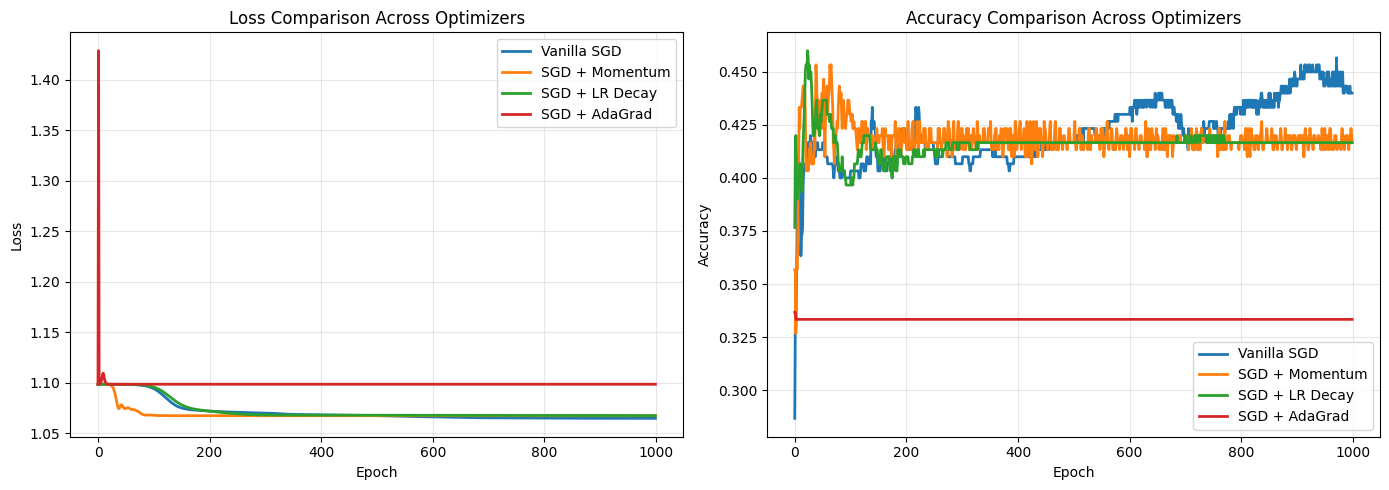

In [15]:
import matplotlib.pyplot as plt

# Plot loss curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_vanilla, label='Vanilla SGD', linewidth=2)
plt.plot(loss_momentum, label='SGD + Momentum', linewidth=2)
plt.plot(loss_decay, label='SGD + LR Decay', linewidth=2)
plt.plot(loss_adagrad, label='SGD + AdaGrad', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison Across Optimizers')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(acc_vanilla, label='Vanilla SGD', linewidth=2)
plt.plot(acc_momentum, label='SGD + Momentum', linewidth=2)
plt.plot(acc_decay, label='SGD + LR Decay', linewidth=2)
plt.plot(acc_adagrad, label='SGD + AdaGrad', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Optimizers')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Analysis and Conclusions

**Key Observations:**

1. **Vanilla SGD (Baseline)**
   - Standard gradient descent without any enhancements
   - Provides a baseline for comparison

2. **SGD with Momentum (γ = 0.9)**
   - Uses momentum to accelerate convergence
   - Helps overcome local minima and plateaus
   - Formula: θ_new = θ - ((η * ∂E/∂θ) + (γ * Δθ^(t-1)))

3. **SGD with Learning Rate Decay**
   - Gradually reduces learning rate over time
   - Helps fine-tune weights in later epochs
   - Can lead to better convergence

4. **SGD with AdaGrad**
   - Adapts learning rate for each parameter
   - Useful for sparse data
   - Learning rate decreases more for frequently updated parameters

Run all the cells above to see which optimizer performs best!